In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"herutriana","key":"1f5588e47d5771a1aebc6f7d7701a0d8"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mistag/arthropod-taxonomy-orders-object-detection-dataset

100% 11.1G/11.1G [04:47<00:00, 71.3MB/s]
100% 11.1G/11.1G [04:48<00:00, 41.4MB/s]


In [5]:
import tensorflow as tensor
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import zipfile,os
zip_lcl = '/content/arthropod-taxonomy-orders-object-detection-dataset.zip'
rzip = zipfile.ZipFile(zip_lcl, 'r')
rzip.extractall('/tmp')
rzip.close()
 
dirbase = '/tmp'

In [7]:
os.listdir('/tmp/ArTaxOr')

['Diptera',
 'Hemiptera',
 'Odonata',
 'Araneae',
 'revision history.txt',
 'Lepidoptera',
 'readme.txt',
 'license.txt',
 'ArTaxOr.png',
 'Hymenoptera',
 'Coleoptera']

In [8]:
dir = os.path.join('/tmp/ArTaxOr')

In [33]:
data_generator = ImageDataGenerator(
    validation_split=0.4,
    shear_range=0.05,
    fill_mode='nearest')

In [34]:
generator_latih = data_generator.flow_from_directory(
    directory=dir,
    target_size=(150,150),
    batch_size=14,
    subset='training',
    class_mode='categorical')
generator_valid = data_generator.flow_from_directory(
    directory=dir,
    target_size=(150,150),
    batch_size=14,
    subset='validation',
    class_mode='categorical')

Found 9228 images belonging to 7 classes.
Found 6148 images belonging to 7 classes.


In [35]:
model = tensor.keras.models.Sequential([
  tensor.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
  tensor.keras.layers.MaxPooling2D(2,2),
  tensor.keras.layers.Conv2D(64,(3,3),activation='relu'),
  tensor.keras.layers.MaxPooling2D(2,2),
  tensor.keras.layers.Conv2D(128,(3,3),activation='relu'),
  tensor.keras.layers.MaxPooling2D(2,2),
  tensor.keras.layers.Flatten(),
  tensor.keras.layers.Dense(512,activation='relu'),
  tensor.keras.layers.Dense(7,activation='softmax')
  ])

In [36]:
model.compile(loss='categorical_crossentropy',optimizer=tensor.optimizers.Adam(),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

In [37]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
earstop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)
cekmodel = ModelCheckpoint(filepath='model.hdf5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

In [38]:
history = model.fit(
    generator_latih,
    steps_per_epoch=6,
    epochs=40,
    validation_data=generator_valid,
    validation_steps=6,
    verbose=2,
    callbacks=[cekmodel])

Epoch 1/40
6/6 - 22s - loss: 459.3126 - accuracy: 0.1310 - val_loss: 10.7383 - val_accuracy: 0.1667

Epoch 00001: val_accuracy improved from -inf to 0.16667, saving model to model.hdf5
Epoch 2/40
6/6 - 18s - loss: 7.3080 - accuracy: 0.1429 - val_loss: 1.9650 - val_accuracy: 0.2143

Epoch 00002: val_accuracy improved from 0.16667 to 0.21429, saving model to model.hdf5
Epoch 3/40
6/6 - 19s - loss: 2.0245 - accuracy: 0.1429 - val_loss: 1.9541 - val_accuracy: 0.1429

Epoch 00003: val_accuracy did not improve from 0.21429
Epoch 4/40
6/6 - 18s - loss: 1.9551 - accuracy: 0.1667 - val_loss: 1.9509 - val_accuracy: 0.1190

Epoch 00004: val_accuracy did not improve from 0.21429
Epoch 5/40
6/6 - 18s - loss: 1.9622 - accuracy: 0.2024 - val_loss: 1.9453 - val_accuracy: 0.1667

Epoch 00005: val_accuracy did not improve from 0.21429
Epoch 6/40
6/6 - 19s - loss: 1.9548 - accuracy: 0.1667 - val_loss: 1.9542 - val_accuracy: 0.1429

Epoch 00006: val_accuracy did not improve from 0.21429
Epoch 7/40
6/6 - 1

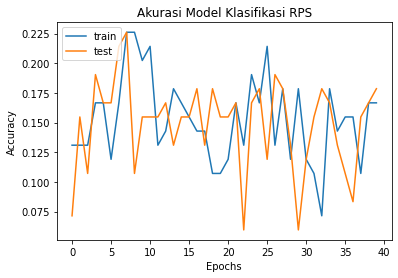

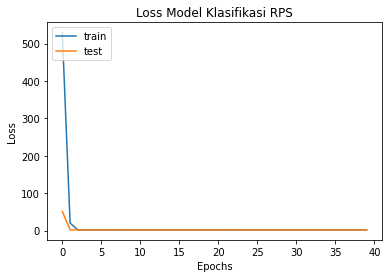

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model Klasifikasi RPS')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model Klasifikasi RPS')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
pengubah = tensor.lite.TFLiteConverter.from_keras_model(model)
tflite_model = pengubah.convert()

INFO:tensorflow:Assets written to: /tmp/tmpvcnzoqul/assets


In [18]:
with tensor.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [19]:
model.save('model.pb') 
%cd

INFO:tensorflow:Assets written to: model.pb/assets


INFO:tensorflow:Assets written to: model.pb/assets


/root
